<a href="https://colab.research.google.com/github/ChristopherLiew/Classifying-Red-Wine-Quality/blob/master/Random_Forest_Classifier_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Random Forest Classifier</h1>


<h2>Import Libraries & Load the data</h2>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel #Further feature selection using feat. importance
from sklearn.inspection import permutation_importance

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
wine_df = pd.read_csv("/content/gdrive/My Drive/Business Analytics Stuff/BT2101 Group Project/winequality-red.csv")

<h2>Preprocessing & Splitting the data into Training & Testing sets</h2>

In [0]:
# Creating the Binary Target Variable
wine_df["good_quality"] = wine_df["quality"] >= 7

# Target Variable
target = wine_df.loc[:, 'good_quality']
target = target.astype(int)  # 1 = good quality & 0 = other quality

# Interaction Terms
final_df = wine_df.drop(columns=['quality', 'good_quality']).copy()
final_df['total acidity'] = final_df['fixed acidity'] + final_df['volatile acidity']
final_df['pH_sulphate'] = final_df['pH'] * final_df['sulphates']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(final_df, target, test_size=0.25,random_state=0)

<h2> Optimising Random Forest with Hyperparameter Tuning using Random & Grid Search</h2>

In [0]:
# Random Forest Classifier
RF_classifier = RandomForestClassifier()

# Hyperparameter Tuning with RandomSearchCV & GridSearchCV
# 1. Reduce parameter search soace using RandomSearchCV first
rnd_param = {
    'n_estimators': [100, 300, 500, 800, 1000, 1200, 1400],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'class_weight': ['balanced_subsample', 'balanced', None]
}

rnd_sr = RandomizedSearchCV(estimator=RF_classifier,
                            param_distributions=rnd_param,
                            scoring="f1_macro",
                            n_iter=100,
                            cv=5,
                            n_jobs=-1)

rnd_sr.fit(X_train, y_train)

rnd_sr.best_score_ # 0.78059
rnd_sr.best_params_ # Optimal Parameters {'n_estimators': 800, 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True}

# 2. Search shrunken parameter space with GridSearchCV
grid_param = {
    'n_estimators': [600, 700, 800, 900, 1000],
    'max_depth': [5, 10, 15, 20],
    'class_weight': ['balanced_subsample', 'balanced', None]
}
gd_sr = GridSearchCV(estimator=RF_classifier,
                     param_grid=grid_param,
                     scoring='f1_macro',
                     cv=10,
                     n_jobs=-1)

gd_sr.fit(X_train, y_train)

gd_sr.best_params_ # Final Optimal Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 800}
gd_sr.best_score_ # 0.78731

<h2>Training the Optimised Random Forest Classifier</h2>

In [0]:
# Train Optimised Random Forest Classifier
RF_classifier = RandomForestClassifier(n_estimators=800, criterion="gini", random_state=0, bootstrap=True, max_depth=10, class_weight="balanced", oob_score=True)
RF_classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = RF_classifier.predict(X_test)

<h2> Validation Curve with respect to n_estimators</h2>

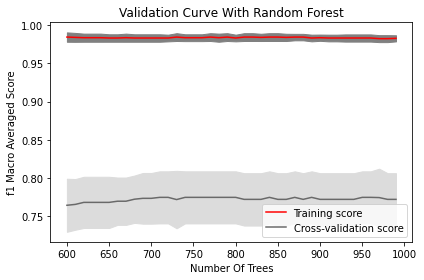

In [0]:
# Validation Curve wrt n_estimators
param_range = np.arange(600, 1000, 10)
train_scores, test_scores = validation_curve(RF_classifier,
                                             X_train,
                                             y_train,
                                             param_name="n_estimators",
                                             param_range=param_range,
                                             cv=5,
                                             scoring="f1_macro",
                                             n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean f1_macro scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="red")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot f1_macro bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("f1 Macro Averaged Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

<h2> Evaluating Random Forests</h2>

In [0]:
# Evaluating the Random Forest Classifier using Classification Report
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.954545,0.946479,0.950495,355.0000
1,0.604167,0.644444,0.623656,45.0000
accuracy,0.912500,0.912500,0.912500,0.9125
macro avg,0.779356,0.795462,0.787075,400.0000
weighted avg,0.915128,0.912500,0.913726,400.0000


In [0]:
# Cross Validated Score (f1_macro & f1 - Skewed by imbalanced data)
cv_score_f1_macro = cross_val_score(RF_classifier, final_df, target, cv=10, scoring="f1_macro")
print("Cross-Val F1-macro Score: %0.3f" % (np.mean(cv_score_f1_macro))) # 0.696
cv_score_f1 = cross_val_score(RF_classifier, final_df, target, cv=10, scoring="f1")
print("Cross-Val F1 Score: %0.3f" % (np.mean(cv_score_f1))) # 0.46594
cv_score_recall = cross_val_score(RF_classifier, final_df, target, cv=10, scoring="recall")
print("Cross-Val Recall Score: %0.3f" % (np.mean(cv_score_recall))) # 0.4222
cv_score_prec = cross_val_score(RF_classifier, final_df, target, cv=10, scoring="precision")
print("Cross-Val Precision Score: %0.3f" % (np.mean(cv_score_prec)))  # 0.6243

Cross-Val F1-macro Score: 0.696
Cross-Val F1 Score: 0.466
Cross-Val Recall Score: 0.422
Cross-Val Precision Score: 0.624


Random Forest AUROC: 0.921


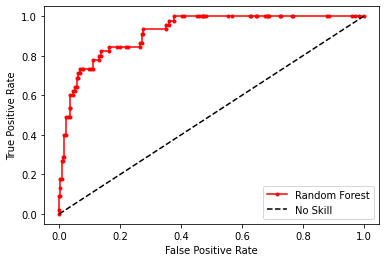

In [0]:
# ROC AUC
# prediction probabilities
rf_probs = RF_classifier.predict_proba(X_test)
# generate no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
# calculate scores
rf_auc = roc_auc_score(y_test, rf_probs) # AUC = 0.921
ns_auc = roc_auc_score(y_test, ns_probs)
# summarize scores
print('Random Forest AUROC: %.3f' % (rf_auc))
# calculate ROC curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# plot the ROC curve for the Random Forest Classifier
#plt.plot([], [], ' ', label="AUROC: 0.921")
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest', color = "red")
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color = "black")
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

<h3> Precision Recall Curve</h3>

In [0]:
from sklearn.metrics import precision_recall_curve

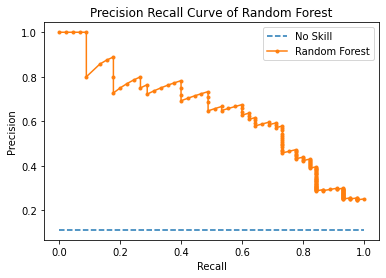

In [0]:
rf_probs = RF_classifier.predict_proba(X_test)
rf_probs = rf_probs[:, 1] # Keep probability predictions for good quality (=1) class only
precisions, recalls, _ = precision_recall_curve(y_test, rf_probs)

# Plot PR-Curve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recalls, precisions, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# annotate optimised model's recall and precision
# Title
plt.title("Precision Recall Curve of Random Forest")
# show the plot
plt.show()

In [0]:
np.where(np.round(precisions, 8) == 0.60416667) #126
np.where(np.round(recalls, 8) == 0.64444444) #126

(array([124, 125, 126, 127]),)

<h2> Feature Importance & Hypotheses Testing </h2>

<h3>Feature Importance (Based on MDI)</h3>

fixed acidity = 0.04380730039422046
volatile acidity = 0.12236288677124622
citric acid = 0.07754877814621361
residual sugar = 0.042887346068360914
chlorides = 0.05648488574229379
free sulfur dioxide = 0.04171485361163986
total sulfur dioxide = 0.06457645754149643
density = 0.0612053137218189
pH = 0.043301573199190736
sulphates = 0.10089026653155889
alcohol = 0.2009553429222048
total acidity = 0.047401050680537106
pH_sulphate = 0.09686394466921823


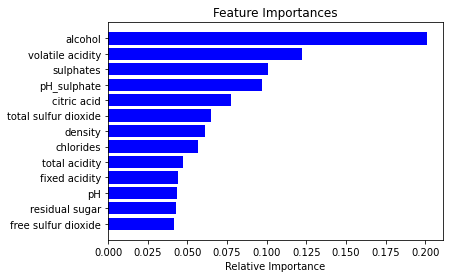

In [0]:
# Feature Importance (Hypotheses Test as well)
for name, importance in zip(final_df.columns, RF_classifier.feature_importances_):
    print(name, "=", importance)

features = final_df.columns
importances = RF_classifier.feature_importances_
indices = np.argsort(importances)

# Graphing it
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<h3>Further Feature Selection using Feature Importance</h3>

In [0]:
# Further Feature Selection for optimisation using Feat. Importance
selector = SelectFromModel(RF_classifier, threshold=0.10)
X_important = selector.fit_transform(X_train, y_train)
RF_classifier.fit(X_important, y_train)
X_important_test = X_test.loc[:, ["alcohol", "volatile acidity", "sulphates"]]
y_pred2 = RF_classifier.predict(X_important_test)
pd.DataFrame(classification_report(y_test, y_pred2, output_dict=True)).transpose()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.887500,1.0000,0.940397,355.0000
1,0.000000,0.0000,0.000000,45.0000
accuracy,0.887500,0.8875,0.887500,0.8875
macro avg,0.443750,0.5000,0.470199,400.0000
weighted avg,0.787656,0.8875,0.834603,400.0000


In [0]:
print("Cross Val F1-macro Score:  %0.3f" % np.mean(cross_val_score(RF_classifier, final_df, target, cv=10, scoring="f1_macro")))
# We observe that feature importances are highly biased by the dominant class
# Solutions: 1) Balance the dataset with SMOTE 2) Class wise feature importance

Cross Val F1-macro Score:  0.696


<h3>Permutation Importance</h3>

In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
# Permutation Importance (eli5)
import eli5
from eli5.sklearn import PermutationImportance
RF_classifier = RandomForestClassifier(n_estimators=800, criterion="gini", random_state=0, bootstrap=True, max_depth=10, class_weight="balanced", oob_score=True)
RF_classifier.fit(X_train, y_train)
perm = PermutationImportance(RF_classifier, random_state=1, scoring="f1_macro", n_iter=10).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist()) # See on Jupyter Notebook


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Weight,Feature
0.1255 ± 0.0711,alcohol
0.0669 ± 0.0530,sulphates
0.0608 ± 0.0474,volatile acidity
0.0389 ± 0.0363,citric acid
0.0322 ± 0.0426,pH_sulphate
0.0232 ± 0.0250,chlorides
0.0187 ± 0.0258,density
0.0154 ± 0.0234,residual sugar
0.0142 ± 0.0261,total sulfur dioxide
0.0135 ± 0.0157,fixed acidity


In [0]:
# Results from Perm Importance ELI5 Feature Selection
X_train_eli5 = X_train.copy()
X_train_eli5 = X_train_eli5.drop(columns = ['pH', 'free sulfur dioxide'])
RF_classifier_eli5 = RandomForestClassifier(n_estimators=800, criterion="gini", random_state=0, bootstrap=True, max_depth=10, class_weight="balanced", oob_score=True)
RF_classifier_eli5.fit(X_train_eli5, y_train)
y_pred = RF_classifier_eli5.predict(X_test.drop(columns =  ['pH', 'free sulfur dioxide']))
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.962751,0.946479,0.954545,355.00
1,0.627451,0.711111,0.666667,45.00
accuracy,0.920000,0.920000,0.920000,0.92
macro avg,0.795101,0.828795,0.810606,400.00
weighted avg,0.925029,0.920000,0.922159,400.00


In [0]:
# Cross Val for Refined Model
# Cross Validated Score 
final_df_eli5 = final_df.drop(columns = ['pH', 'free sulfur dioxide'])
cv_score_f1_macro = cross_val_score(RF_classifier_eli5, final_df_eli5, target, cv=10, scoring="f1_macro")
print("Cross-Val F1-macro Score: %0.3f" % (np.mean(cv_score_f1_macro))) # 0.700
cv_score_f1 = cross_val_score(RF_classifier_eli5, final_df_eli5, target, cv=10, scoring="f1")
print("Cross-Val F1 Score: %0.3f" % (np.mean(cv_score_f1))) # 0.473
cv_score_recall = cross_val_score(RF_classifier_eli5, final_df_eli5, target, cv=10, scoring="recall")
print("Cross-Val Recall Score: %0.3f" % (np.mean(cv_score_recall))) # 0.436
cv_score_prec = cross_val_score(RF_classifier_eli5, final_df_eli5, target, cv=10, scoring="precision")
print("Cross-Val Precision Score: %0.3f" % (np.mean(cv_score_prec)))  # 0.625

Cross-Val F1-macro Score: 0.700
Cross-Val F1 Score: 0.473
Cross-Val Recall Score: 0.436
Cross-Val Precision Score: 0.625


<p> f1_macro, recall and precision all improve with negative perm importance features dropped</p>

<h3>Drop Column Feature Importance (Measured using fall in f1-macro)</h3>

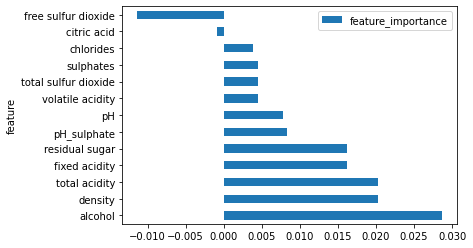

In [0]:
# Drop Column Feature Importance
from sklearn.base import clone

# Helper Function
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

# Drop Col Feat Importance Function
from sklearn.metrics import f1_score

def drop_col_feat_imp(model, X_train, y_train, X_test, y_test, random_state=42):
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    # y_pred
    y_pred = model_clone.predict(X_test) # *
    benchmark_score = f1_score(y_test, y_pred, average='macro') #model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []

    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis=1), y_train)
        y_pred = model_clone.predict(X_test.drop(col, axis=1)) # *
        drop_col_score = f1_score(y_test, y_pred, average='macro') #model_clone.score(X_train.drop(col, axis=1), y_train)
        importances.append(benchmark_score - drop_col_score)

    importances_df = imp_df(X_train.columns, importances)
    return importances_df

drop_col_results = drop_col_feat_imp(RF_classifier, X_train, y_train, X_test, y_test)

# Graphing it
drop_col_results.plot.barh(x='feature', y='feature_importance')
plt.show()